### Load Tensorflow Libraries

In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K

tf.enable_eager_execution()

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

### Use one vGPU

In [2]:
!nvidia-smi

Sun Aug 25 18:07:28 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:62:00.0 Off |                    0 |
| N/A   46C    P0    57W / 300W |      0MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:89:00.0 Off |                    0 |
| N/A   45C    P0    55W / 300W |  31405MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### Load custom libraries

In [4]:
if tf.io.gfile.exists('./nn_utils'):
  tf.io.gfile.rmtree('./nn_utils')
!git clone https://github.com/ashxjain/nn_utils.git

Cloning into 'nn_utils'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 104 (delta 57), reused 74 (delta 29), pack-reused 0
Receiving objects: 100% (104/104), 17.45 KiB | 0 bytes/s, done.
Resolving deltas: 100% (57/57), done.
Checking connectivity... done.


In [5]:
import numpy as np
import pickle
import os
import urllib
import zipfile 
import tarfile
from six.moves import urllib

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# tf.keras imports
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv2D, Activation, Flatten, MaxPool2D, GlobalMaxPooling2D, Add, Lambda
from tensorflow.keras.layers import BatchNormalization, AveragePooling2D, Input, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

# import for showing the confusion matrix
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.regularizers import l2

import time, math

from nn_utils import lr_utils

In [6]:
tf.__version__

'1.14.0'

### Generate TFRecords

* Generate 50000 Training dataset
* Generate 10000 Validation dataset
* Generate 50000 * 12 Augmented dataset

In [7]:
"""
Read CIFAR-10 data from pickled numpy arrays and writes TFRecords.
Generates tf.train.Example protos and writes them to TFRecord files from the
python version of the CIFAR-10 dataset downloaded from
https://www.cs.toronto.edu/~kriz/cifar.html.
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import os
import sys

import tarfile
from six.moves import cPickle as pickle
from six.moves import xrange
import tensorflow as tf
import numpy as np

from tensorflow.python.keras.utils.data_utils import Sequence, is_generator_or_sequence
from albumentations import (
    Compose, HorizontalFlip, RandomCrop, ToFloat, PadIfNeeded, Normalize, Cutout,Rotate
)
import cv2
from matplotlib import pyplot as plt



CIFAR_FILENAME = 'cifar-10-python.tar.gz'
CIFAR_DOWNLOAD_URL = 'https://www.cs.toronto.edu/~kriz/' + CIFAR_FILENAME
CIFAR_LOCAL_FOLDER = 'cifar-10-batches-py'


def download_and_extract(data_dir):
  # download CIFAR-10 if not already downloaded.
  tf.contrib.learn.datasets.base.maybe_download(CIFAR_FILENAME, data_dir,
                                                CIFAR_DOWNLOAD_URL)
  tarfile.open(os.path.join(data_dir, CIFAR_FILENAME),
               'r:gz').extractall(data_dir)


def _int64_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def _bytes_feature(value):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def _get_file_names():
  """Returns the file names expected to exist in the input_dir."""
  file_names = {}
  file_names['train'] = ['data_batch_%d' % i for i in xrange(1, 6)]
  for aug_idx in range(1, 13):
      file_names['augmented_train_'+str(aug_idx)] = ['data_batch_%d' % i for i in xrange(1, 6)]  
  file_names['eval'] = ['test_batch']
  return file_names


def read_pickle_from_file(filename):
  with tf.gfile.Open(filename, 'rb') as f:
    if sys.version_info >= (3, 0):
      data_dict = pickle.load(f, encoding='bytes')
    else:
      data_dict = pickle.load(f)
  return data_dict

AUGMENTATIONS_TRAIN = Compose([
    RandomCrop(32, 32),
    HorizontalFlip(p=0.5),
    Cutout(num_holes=1, p=1.0),
])

def preprocess_image(image_raw):
    x_train = image_raw.reshape(10000, 32, 32, 3)

    pad4 = lambda x: np.pad(x, [(0, 0), (4, 4), (4, 4), (0, 0)], mode='reflect')

    x_train = pad4(x_train)
    augmented_x = np.zeros((x_train.shape[0], 32, 32, 3))
    for i in range(x_train.shape[0]):
        augmented_x[i] = AUGMENTATIONS_TRAIN(image=x_train[i])["image"]
        
    x_train = augmented_x.reshape(10000, 32*32*3).astype(np.int8)
    return x_train
    
def convert_to_tfrecord(input_files, output_file, output_prefix):
  """Converts a file to TFRecords."""
  print('Generating %s...' % output_file, end='')
  count = 0
  with tf.python_io.TFRecordWriter(output_file) as record_writer:
    for input_file in input_files:
      data_dict = read_pickle_from_file(input_file)
      data = data_dict[b'data']
      labels = data_dict[b'labels']
      num_entries_in_batch = len(labels)
      if output_prefix.startswith("augmented_train"):
        data = preprocess_image(data)
      for i in range(num_entries_in_batch):
        example = tf.train.Example(features=tf.train.Features(
            feature={
                'image': _bytes_feature(data[i].tobytes()),
                'label': _int64_feature(labels[i])
            }))
        record_writer.write(example.SerializeToString())
      count += num_entries_in_batch
  print('Done [%d records]' % (len(input_files)*num_entries_in_batch))

def main(data_dir):
  print('Download from {} and extract.'.format(CIFAR_DOWNLOAD_URL))
  download_and_extract(data_dir)
  file_names = _get_file_names()
  input_dir = os.path.join(data_dir, CIFAR_LOCAL_FOLDER)
  for mode, files in sorted(file_names.items(), key=lambda item: item[0]):
    input_files = [os.path.join(input_dir, f) for f in files]
    output_file = os.path.join(data_dir, mode + '.tfrecords')
    try:
      os.remove(output_file)
    except OSError:
      pass
    # Convert to tf.train.Example and write the to TFRecords.
    convert_to_tfrecord(input_files, output_file, mode)
  print('Done!')


if __name__ == '__main__':
  main("/root/tfrecords")

Download from https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz and extract.


W0825 18:07:54.321067 140465225697024 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0825 18:07:54.322296 140465225697024 deprecation.py:323] From <ipython-input-7-24289f2026fb>:39: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.


Generating /root/tfrecords/augmented_train_1.tfrecords...Done [50000 records]
Generating /root/tfrecords/augmented_train_10.tfrecords...Done [50000 records]
Generating /root/tfrecords/augmented_train_11.tfrecords...Done [50000 records]
Generating /root/tfrecords/augmented_train_12.tfrecords...Done [50000 records]
Generating /root/tfrecords/augmented_train_2.tfrecords...Done [50000 records]
Generating /root/tfrecords/augmented_train_3.tfrecords...Done [50000 records]
Generating /root/tfrecords/augmented_train_4.tfrecords...Done [50000 records]
Generating /root/tfrecords/augmented_train_5.tfrecords...Done [50000 records]
Generating /root/tfrecords/augmented_train_6.tfrecords...Done [50000 records]
Generating /root/tfrecords/augmented_train_7.tfrecords...Done [50000 records]
Generating /root/tfrecords/augmented_train_8.tfrecords...Done [50000 records]
Generating /root/tfrecords/augmented_train_9.tfrecords...Done [50000 records]
Generating /root/tfrecords/eval.tfrecords...Done [10000 recor

### Model: DavidNet

In [8]:
def init_pytorch(shape, dtype=tf.float32, partition_info=None):
  fan = np.prod(shape[:-1])
  bound = 1 / math.sqrt(fan)
  return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

def ConvBN(c, x):
  x = Conv2D(c, (3, 3), padding='same', kernel_regularizer=l2(weight_decay),kernel_initializer=init_pytorch, use_bias=False) (x)
  x = (BatchNormalization(momentum=0.9)) (x)
  x = (Activation('relu')) (x)
  return x

def layer(c, x):
  x = ConvBN(c, x)
  x = MaxPool2D (pool_size=(2, 2))(x)
  x1 = ConvBN(c, x)
  x1 = ConvBN(c, x1)
  x1 = Add()([x1, x])
  return x1

def build(c=64, lr=0.02, tensor=None, out_tensor=None):
  if tensor is not None:
     _input = Input(tensor=tensor)
  else:
     _input = Input(shape=(32,32,3))
  x = ConvBN (c, _input)
  #Layer1
  x = layer(c*2, x)
  x = ConvBN(c*4, x)
  x = MaxPool2D (pool_size=(2, 2))(x)
  #Layer2
  x = layer(c*8, x)
  x = GlobalMaxPooling2D()(x)
  x = Flatten()(x)
  x = Dense(10, kernel_initializer=init_pytorch, kernel_regularizer=l2(weight_decay), use_bias=False) (x)
  x = Lambda(lambda x: x *0.125)(x)
  _output = Activation('softmax')(x)
  model = Model(inputs=_input, outputs=_output)
  
  optimizer = SGD(lr=lr, momentum=0.9, nesterov=True)
  if out_tensor is not None:
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'], target_tensors=[out_tensor])
  else:
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model

### Hyper-Parameters

In [17]:
nb_epoch = 24
batch_size = 512
weight_decay = 1e-4

### Visualize OneCycleLR Policy Graph

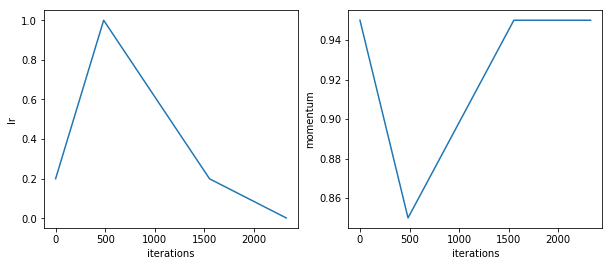

In [10]:
max_lr=1
lr_manager = lr_utils.OneCycleLR(
    sl_epoch=5,
    end_epoch=8,
    max_lr=max_lr, min_lr=max_lr/5.0,
    maximum_momentum=0.95,
    verbose=True,
    batch_size=batch_size,
    steps_per_epoch=50000//batch_size
)
lr_manager.test_run(epochs=24)

### Load TFRecords
* In every step, load 256 images from training set and 256 from augmented set = 512 images per step
* 1 epoch == 97 step == (256+256) * 97 images ~= 50000 images

In [22]:
IMAGE_HEIGHT = 32
IMAGE_WIDTH = 32
IMAGE_DEPTH = 3
NUM_CLASSES = 10
rgb_mean = tf.constant((0.4914, 0.4822, 0.4465), dtype=tf.float32)
rgb_std = tf.constant((0.2470, 0.2435, 0.2616), dtype=tf.float32)

def parse_record(serialized_example):
    features = tf.parse_single_example(
    serialized_example,
    features={
      'image': tf.FixedLenFeature([], tf.string),
      'label': tf.FixedLenFeature([], tf.int64),
    })

    image = tf.decode_raw(features['image'], tf.uint8)
    image.set_shape([IMAGE_DEPTH * IMAGE_HEIGHT * IMAGE_WIDTH])
    image = tf.reshape(image, [IMAGE_DEPTH, IMAGE_HEIGHT, IMAGE_WIDTH])
    image = tf.cast(tf.transpose(image, [1, 2, 0]), tf.float32) * (1. / 255.)

    # TODO: Handle normalization for Augmented images as well
    #image = tf.subtract(image, rgb_mean)
    #image = tf.divide(image, rgb_std)

    label = tf.cast(features['label'], tf.int32)
    return image, label

def fetch_dataset(filenames, batch_size, training=False):
    if training:
        files = tf.data.Dataset.from_tensor_slices(filenames)
        dataset = files.interleave(lambda x: tf.data.TFRecordDataset(x), cycle_length=2, block_length=batch_size//2)
    else:
        dataset = tf.data.TFRecordDataset(filenames=filenames)

    if training:
      buffer_size = batch_size * 2 + 1
      dataset = dataset.shuffle(buffer_size=buffer_size)

    # Transformation
    dataset = dataset.map(parse_record, num_parallel_calls=4)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(2 * batch_size)
    return dataset


### Visualize images from TFRecords

In [ ]:
def show_img(img, figsize=(2, 2)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.grid(False)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.imshow(img)
    plt.imshow(img)

files = []
for i in range(1,13):
    files.append("/root/tfrecords/train.tfrecords")
    files.append("/root/tfrecords/augmented_train_"+str(i)+".tfrecords")

dataset = fetch_dataset(files, 2, False)
cnt = 0
for i in dataset:
    cnt += 1
    if cnt == 1 or cnt == 50000 or cnt == 50001:
        for img in i[0]:
            show_img(img)
    if cnt == 50002:
        break

In [23]:
def train_model(max_lr =1, verbose=True):
    if verbose:
      verbose_val = 1
    else:
      verbose_val = 0
    checkpoint = ModelCheckpoint("assignment_14_weights.hdf5", monitor='val_acc', verbose=verbose_val, save_best_only=True, mode='max')


    lr_manager = lr_utils.OneCycleLR(sl_epoch=5,
                        end_epoch=8,
                        max_lr=max_lr, min_lr=max_lr/5.0,
                        maximum_momentum=0.95,
                        verbose=verbose,
                        batch_size=batch_size,
                        steps_per_epoch=50000//batch_size)

    files = []
    for i in range(1,13):
        files.append("/root/tfrecords/train.tfrecords")
        files.append("/root/tfrecords/augmented_train_"+str(i)+".tfrecords")
    train_data = fetch_dataset(files, batch_size, True)
    val_data = fetch_dataset(["/root/tfrecords/eval.tfrecords"], batch_size)

    callbacks=[lr_manager, checkpoint]

    train_history = model.fit(
      train_data,
      epochs=nb_epoch, steps_per_epoch=50000//batch_size,
      validation_data=val_data, validation_steps=10000//batch_size,
      callbacks=callbacks)

    return train_history

### Final Model Run

In [ ]:
import tensorflow.keras.backend as K

lr=0.6

model = build(lr=lr)

K.set_value(model.optimizer.decay, 0.0005 * batch_size)

train_history = train_model(max_lr=lr)

Epoch 1/24
96/97 [============================>.] - ETA: 0s - loss: 1.6306 - acc: 0.4276 - lr: 0.21501 - momentum: 0.93 

Epoch 00001: val_acc improved from -inf to 0.53382, saving model to assignment_14_weights.hdf5
97/97 [==============================] - 15s 154ms/step - loss: 1.6265 - acc: 0.4293 - val_loss: 1.3739 - val_acc: 0.5338
Epoch 2/24
96/97 [============================>.] - ETA: 0s - loss: 1.2074 - acc: 0.6042 - lr: 0.31101 - momentum: 0.91 

Epoch 00002: val_acc improved from 0.53382 to 0.61246, saving model to assignment_14_weights.hdf5
97/97 [==============================] - 8s 87ms/step - loss: 1.2064 - acc: 0.6047 - val_loss: 1.2613 - val_acc: 0.6125
Epoch 3/24
96/97 [============================>.] - ETA: 0s - loss: 1.0729 - acc: 0.6643 - lr: 0.40701 - momentum: 0.89 

Epoch 00003: val_acc did not improve from 0.61246
97/97 [==============================] - 8s 85ms/step - loss: 1.0724 - acc: 0.6648 - val_loss: 1.2863 - val_acc: 0.6031
Epoch 4/24
96/97 [===========

### Time taken by: Conv layers & BN layers

In [20]:
import time
from tensorflow.keras.callbacks import Callback
import numpy as np
import tensorflow as tf

class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

def get_average_layer_train_time(model, layer_prefix, epochs):

    #Loop through each layer setting it Trainable and others as non trainable
    time_callback = TimeHistory()
    n_layers = 0
    
    #Setting all layers as non-Trainable
    for i in range(len(model.layers)):
        model.layers[i].trainable = False
        if model.layers[i].name.startswith(layer_prefix):
            model.layers[i].trainable = True
            n_layers += 1

    optimizer = SGD(lr=0.4, momentum=0.9, nesterov=True)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    
    files = []
    for i in range(1,13):
        files.append("/root/tfrecords/train.tfrecords")
        files.append("/root/tfrecords/augmented_train_"+str(i)+".tfrecords")
    train_data = fetch_dataset(files, batch_size, True)

    #Fit on a small number of epochs with callback that records time for each epoch
    model.fit(
        train_data,
        epochs=epochs,
        steps_per_epoch=50000//batch_size,
        callbacks=[time_callback]
    )

    #Print average of the time for each layer
    print(">>", n_layers, layer_prefix, ": Approx (avg) train time for ", epochs, "epochs =", np.average(time_callback.times))

In [21]:
model = build()
get_average_layer_train_time(model, "no-layers", 5)
get_average_layer_train_time(model, "conv", 5)
get_average_layer_train_time(model, "batch_normalization", 5)

Epoch 1/5
97/97 [==============================] - 3s 32ms/step - loss: 2.4127 - acc: 0.0986
Epoch 2/5
97/97 [==============================] - 3s 34ms/step - loss: 2.4161 - acc: 0.0994
Epoch 3/5
97/97 [==============================] - 3s 34ms/step - loss: 2.4133 - acc: 0.0983
Epoch 4/5
97/97 [==============================] - 3s 34ms/step - loss: 2.4160 - acc: 0.0997
Epoch 5/5
97/97 [==============================] - 3s 34ms/step - loss: 2.4133 - acc: 0.0984
>> 0 no-layers : Approx (avg) train time for  5 epochs = 3.260294485092163
Epoch 1/5
97/97 [==============================] - 12s 124ms/step - loss: 1.6657 - acc: 0.4396
Epoch 2/5
97/97 [==============================] - 7s 75ms/step - loss: 1.2820 - acc: 0.6022
Epoch 3/5
97/97 [==============================] - 7s 75ms/step - loss: 1.1371 - acc: 0.6604
Epoch 4/5
97/97 [==============================] - 7s 75ms/step - loss: 1.0578 - acc: 0.6962
Epoch 5/5
97/97 [==============================] - 7s 75ms/step - loss: 0.9920 - acc: 

* No Layers = 3s
* All Conv Layers = 8-3 = 5s
* All BN Layers = 7-3 = 4s